# Solar Panel Adoption in Switzerland: Data Simulation and AI Model Creation

This notebook demonstrates the process of simulating a dataset for solar panel adoption in Switzerland and creating an AI model to predict installation based on various factors.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
plt.style.use('ggplot')
# Set random seed for reproducibility
np.random.seed(42)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

## Data Simulation

First, let's simulate a dataset for solar panel adoption in Switzerland.

In [11]:
# Create a list of cantons
cantons = ['Zurich', 'Bern', 'Lucerne', 'Uri', 'Schwyz', 'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 
           'Solothurn', 'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen', 'Appenzell Ausserrhoden', 
           'Appenzell Innerrhoden', 'St. Gallen', 'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 
           'Valais', 'Neuchâtel', 'Geneva', 'Jura']

# Create a date range
years = range(2010, 2024)

# Create empty lists to store the data
data = []

for year in years:
    for canton in cantons:
        # Generate realistic values for each factor
        energy_price = np.random.uniform(0.15, 0.25)  # CHF/kWh
        feed_in_tariff = np.random.uniform(0.08, 0.15)  # CHF/kWh
        solar_panel_cost = np.random.uniform(2000, 4000)  # CHF/kW
        tax_deduction_rate = np.random.uniform(0.1, 0.3)  # 10-30%
        subsidy_amount = np.random.uniform(300, 1000)  # CHF/kW
        
        # Calculate a "likelihood" score based on the factors
        likelihood = (energy_price - feed_in_tariff) * 1000 + subsidy_amount + tax_deduction_rate * solar_panel_cost - solar_panel_cost/10
        
        # Generate installed solar power based on the likelihood and add some randomness
        base_power = max(0, likelihood * 10)
        installed_power = np.random.normal(base_power, base_power * 0.2)  # 20% standard deviation
        installed_power = max(0, installed_power)  # Ensure non-negative values
        
        # Add time trend: power installations generally increase over time
        time_factor = (year - 2010) / 13  # Normalized time factor
        installed_power *= (1 + time_factor)
        
        # Add the data point to our list
        data.append([year, canton, installed_power, energy_price, feed_in_tariff, solar_panel_cost, tax_deduction_rate, subsidy_amount])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Year', 'Canton', 'Installed_Power', 'Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount'])

# Display the first few rows and dataset shape
print(df.head())
print(f"Dataset shape: {df.shape}")

# Display summary statistics
print("\nSummary Statistics for Installed Power:")
print(df['Installed_Power'].describe())

   Year   Canton  Installed_Power  Energy_Price  Feed_in_Tariff  \
0  2010   Zurich      9131.328826      0.187454        0.146550   
1  2010     Bern     14953.422789      0.220807        0.081441   
2  2010  Lucerne     11068.340142      0.168182        0.092838   
3  2010      Uri      8081.189377      0.163949        0.100450   
4  2010   Schwyz      7117.378619      0.169967        0.115996   

   Solar_Panel_Cost  Tax_Deduction_Rate  Subsidy_Amount  
0       3463.987884            0.219732      409.213048  
1       3939.819704            0.266489      448.637377  
2       2608.484486            0.204951      602.361513  
3       2732.723687            0.191214      849.623173  
4       3184.829138            0.109290      725.281396  
Dataset shape: (364, 8)

Summary Statistics for Installed Power:
count      364.000000
mean     15750.622201
std       6526.511958
min       3849.223252
25%      11076.872815
50%      14442.229895
75%      19980.547497
max      38630.928230
Name: In

## Exploratory Data Analysis

Now let's visualize our simulated data to understand the patterns and relationships.

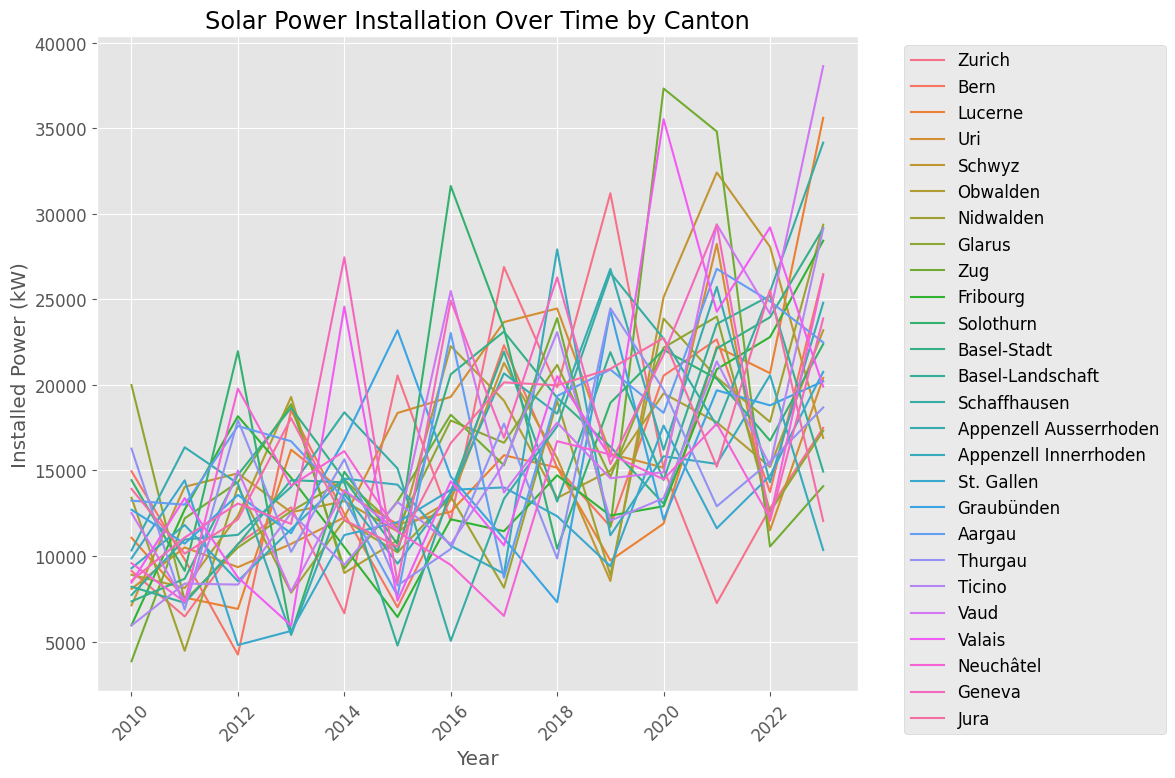

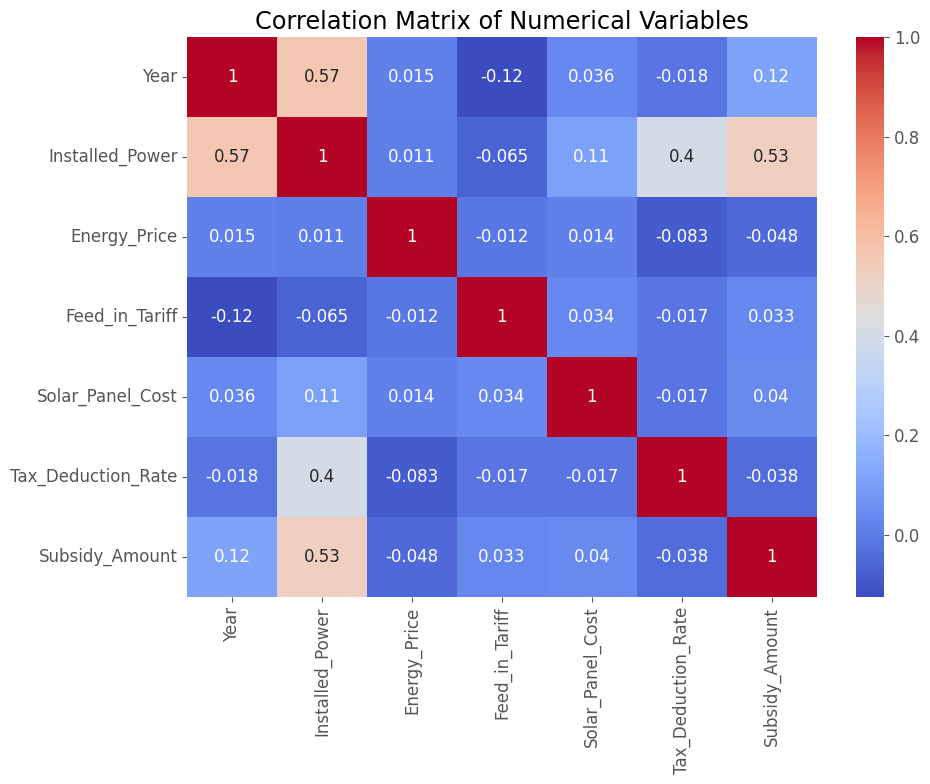

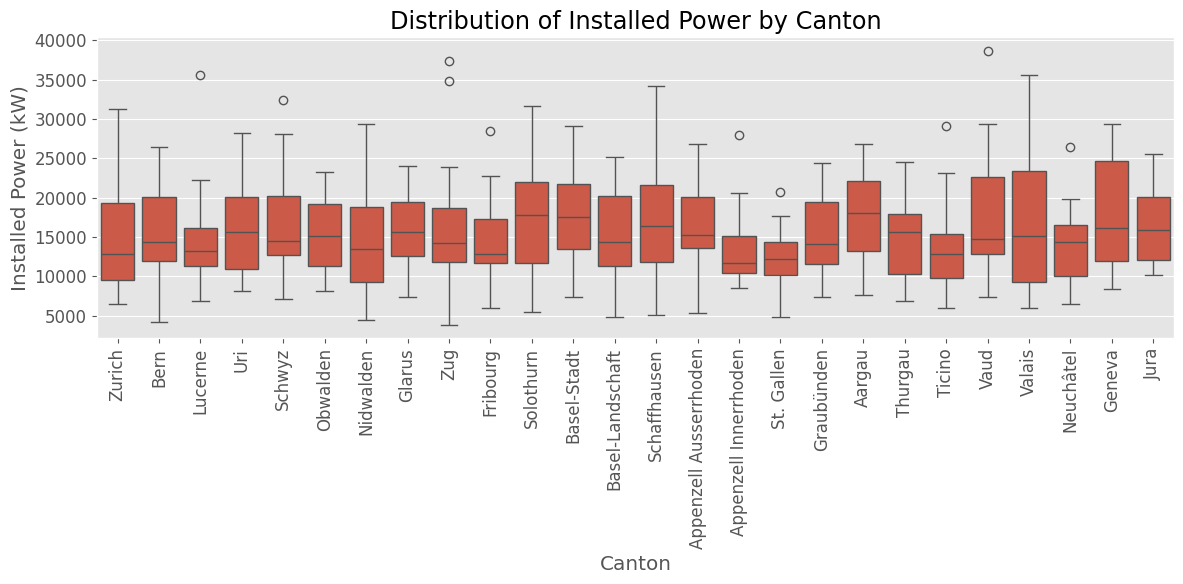

In [12]:
# Solar Power Installation Over Time by Canton
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Year', y='Installed_Power', hue='Canton')
plt.title('Solar Power Installation Over Time by Canton')
plt.ylabel('Installed Power (kW)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.drop('Canton', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Distribution of Installed Power by Canton
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Canton', y='Installed_Power')
plt.title('Distribution of Installed Power by Canton')
plt.xticks(rotation=90)
plt.ylabel('Installed Power (kW)')
plt.tight_layout()
plt.show()

## Model Creation and Evaluation

Now let's create and evaluate our AI model.

In [13]:
# Separate features and target
X = df.drop(['Installed_Power', 'Year'], axis=1)
y = df['Installed_Power']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount']),
        ('cat', OneHotEncoder(drop='first'), ['Canton'])
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = best_model.named_steps['regressor'].feature_importances_
feature_names = (best_model.named_steps['preprocessor']
                 .named_transformers_['num'].get_feature_names_out().tolist() + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat'].get_feature_names_out().tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

Mean Squared Error: 29711295.25884036
R-squared Score: 0.3897629018962546

Feature Importance:
                          feature  importance
4                  Subsidy_Amount    0.401782
3              Tax_Deduction_Rate    0.242229
2                Solar_Panel_Cost    0.096636
0                    Energy_Price    0.078531
1                  Feed_in_Tariff    0.071086
27                    Canton_Vaud    0.023754
28                     Canton_Zug    0.014869
15                 Canton_Lucerne    0.006874
29                  Canton_Zurich    0.006157
20                  Canton_Schwyz    0.004735
19            Canton_Schaffhausen    0.004229
5   Canton_Appenzell Ausserrhoden    0.003884
11                  Canton_Geneva    0.003833
21               Canton_Solothurn    0.003822
13              Canton_Graubünden    0.003731
24                  Canton_Ticino    0.003352
8              Canton_Basel-Stadt    0.003351
16               Canton_Neuchâtel    0.002793
14                    Canton_Ju

## Model Visualization

Let's visualize the model's performance and feature importance.

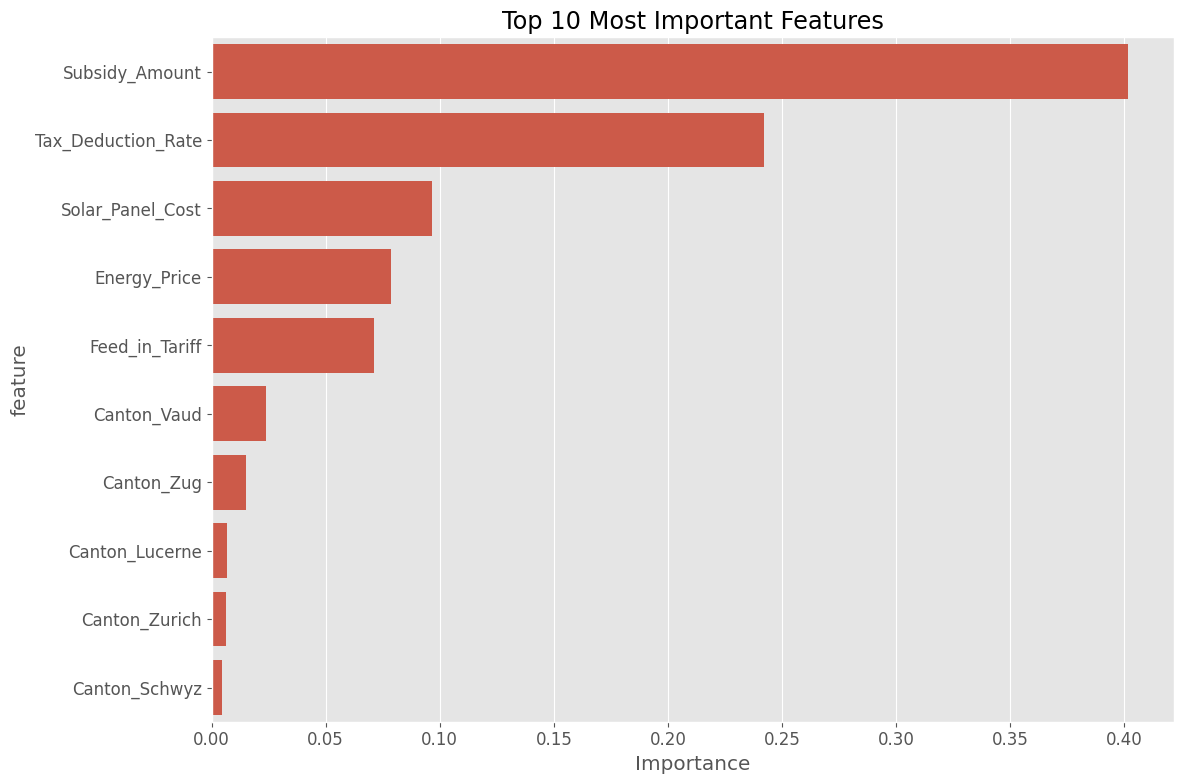

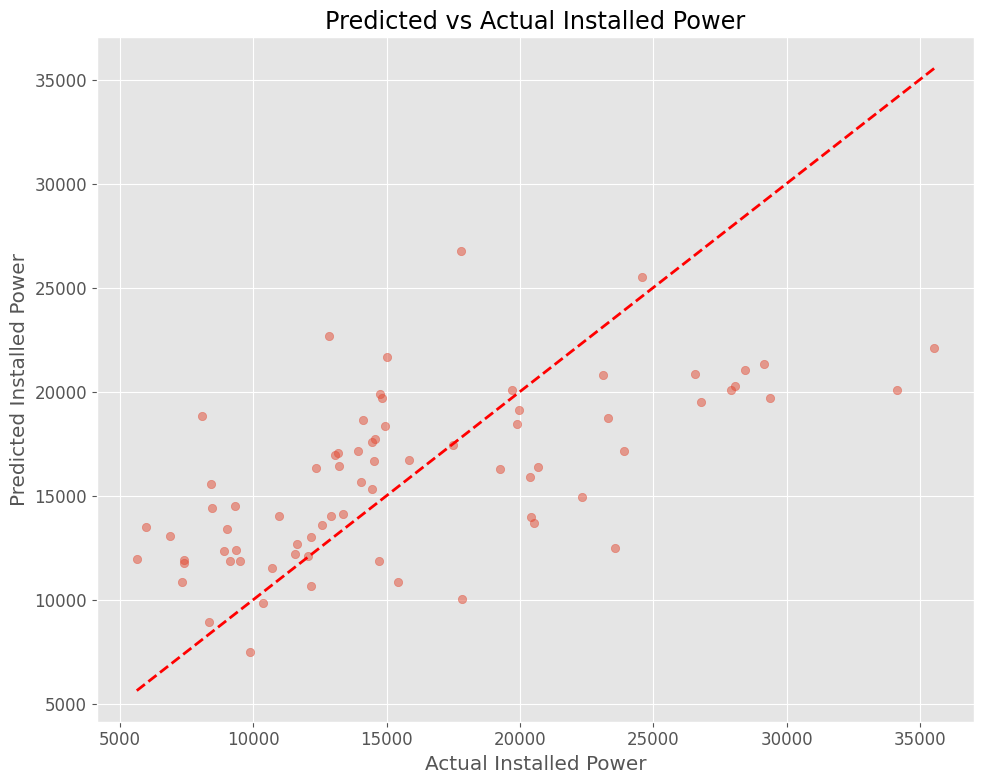

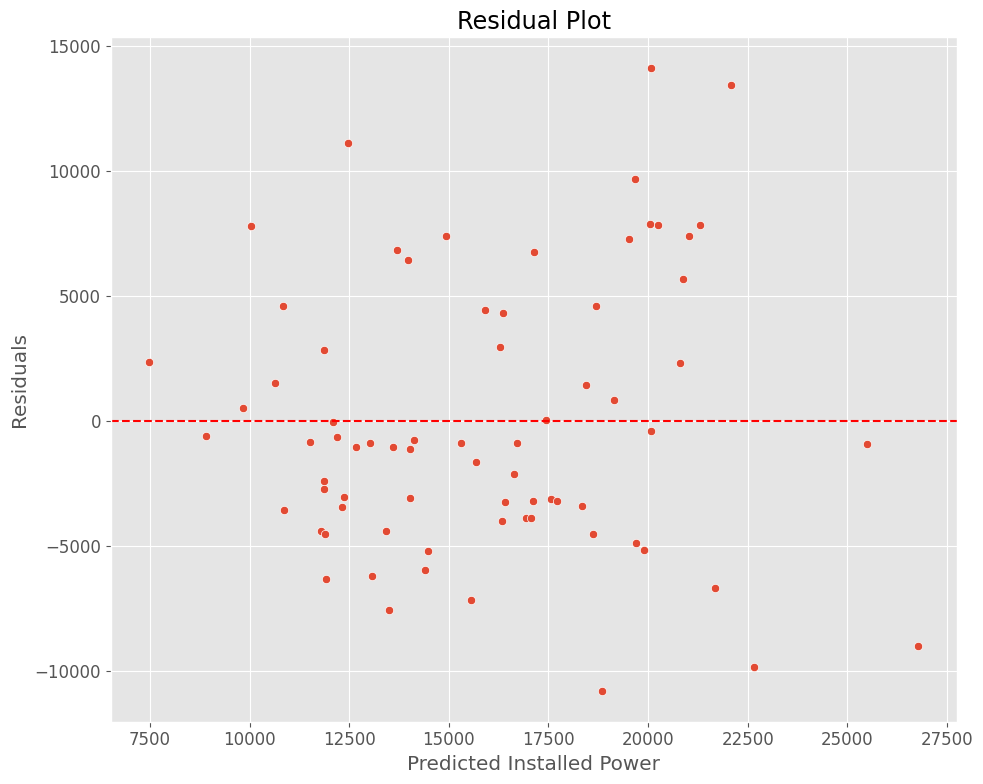

In [14]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Visualize predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Installed Power')
plt.ylabel('Predicted Installed Power')
plt.title('Predicted vs Actual Installed Power')
plt.tight_layout()
plt.show()

# Visualize residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Installed Power')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated the process of simulating a dataset for solar panel adoption in Switzerland, performing exploratory data analysis, creating an AI model to predict installation, and evaluating the model's performance. The visualizations and metrics provide insights into the factors influencing solar panel adoption and the accuracy of our predictions.